In [1]:
!pip install category_encoders==2

     |████████████████████████████████| 92kB 1.3MB/s 


**importing and wangling my Dataframe**

Link to download my data: https://console.cloud.google.com/marketplace/product/noaa-public/hurricanes?filter=solution-type:dataset&id=fa502e93-02a3-4606-8918-5d44a5e8f8f0

In [2]:
import pandas as pd
df = pd.read_csv('/content/bq-results-20201012-170618-9trtsvk0k3u0.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df[['season','number','basin','subbasin','iso_time','latitude','longitude','track_type','dist2land','landfall','usa_agency','usa_sshs', 'usa_pressure']] #removing irrelevant columns
df.dropna(axis = 0, how = 'any', inplace= True) #dropping rows that dont have values for all columns

In [4]:
df.set_index(['season', 'number'], inplace=True) #creating a multindex to first show year then the storn number for that year
df


basin subbasin  ... usa_sshs  usa_pressure
season number                 ...                       
2001   83        WP       MM  ...      4.0         904.0
       83        WP       MM  ...      4.0         910.0
2002   30        WP       MM  ...      4.0         910.0
2003   68        WP       MM  ...      5.0         885.0
2006   93        WP       MM  ...      4.0         904.0
...             ...      ...  ...      ...           ...
2012   26        WP       MM  ...      2.0         956.0
2009   4         SI       MM  ...      3.0         944.0
2012   2         SI       WA  ...      1.0         974.0
2017   24        SP       MM  ...      1.0         974.0
       24        SP       MM  ...      1.0         967.0

[92324 rows x 11 columns]

In [5]:
df = df.sort_index() #Sorting the dataframe to be in order by time

In [6]:
df.head(50)

basin subbasin  ... usa_sshs  usa_pressure
season number                 ...                       
1954   63        EP       MM  ...      0.0         981.0
1957   40        EP       CP  ...      0.0        1004.0
       40        EP       MM  ...      0.0         994.0
       40        EP       CP  ...      0.0         987.0
1958   39        EP       MM  ...      0.0         992.0
1959   55        EP       CP  ...      4.0         952.0
       83        EP       MM  ...      1.0         967.0
       97        EP       MM  ...      4.0         958.0
1960   56        EP       MM  ...      0.0         987.0
1967   94        WP       MM  ...      4.0         933.0
1968   98        EP       MM  ...     -1.0        1008.0
1969   37        EP       MM  ...     -1.0         999.0
       66        EP       MM  ...     -1.0        1006.0
       66        EP       MM  ...      0.0         997.0
       74        EP       MM  ...      0.0         993.0
1970   58        EP       MM  ...      1.0         991.0
       58        EP       MM  ...      0.0        1006.0
       63        EP       MM  ...      0.0        1009.0
       87        EP       MM  ...      1.0         978.0
       87        EP       MM  ...      2.0         963.0
       87        EP       MM  ...      1.0         988.0
       87        EP       MM  ...      0.0         994.0
       99        EP       MM  ...      0.0         992.0
       128       EP       MM  ...      2.0         976.0
       128       EP       MM  ...      2.0         979.0
       128       EP       MM  ...      2.0         980.0
       128       EP       MM  ...      2.0         972.0
       136       EP       MM  ...      0.0        1006.0
       142       EP       MM  ...      0.0         997.0
       142       EP       MM  ...      0.0         995.0
1971   50        EP       MM  ...      1.0         972.0
       61        EP       MM  ...      0.0         980.0
       61        EP       MM  ...      0.0         994.0
       62        EP       MM  ...      3.0         951.0
       62        EP       MM  ...      1.0         963.0
       65        EP       MM  ...      0.0        1009.0
       75        EP       MM  ...      0.0         991.0
       75        EP       MM  ...      0.0        1005.0
       75        EP       MM  ...      0.0         995.0
       78        EP       MM  ...      0.0         991.0
       80        EP       MM  ...      1.0         964.0
       80        EP       MM  ...      1.0         981.0
       82        EP       MM  ...      1.0         978.0
       82        EP       MM  ...      0.0         988.0
       101       EP       MM  ...      0.0        1005.0
       105       EP       MM  ...      1.0         990.0
       105       EP       MM  ...      1.0         996.0
       115       EP       MM  ...      1.0         963.0
       115       EP       MM  ...      1.0         974.0
       115       EP       MM  ...      1.0         980.0

[50 rows x 11 columns]

**Choosing Target and feature matrices**

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
y = df['usa_sshs']
X = df.drop(columns = 'usa_sshs')

**Splitting Data into Train Val and Test Sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # test size is 20% of the data 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # val size is 25% of the train data so it is 20% of the full dataset leaving the train set to be %60 of the data

**Baseline Accuracy: (Using most frequent value in the target matrix as baseline)**

In [12]:
x = y_train.value_counts(normalize = True)
baseline_acc = x

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy:  0.0    0.347529
-1.0    0.246092
-3.0    0.135231
 1.0    0.106817
 2.0    0.051883
 3.0    0.047334
 4.0    0.040365
-4.0    0.011680
 5.0    0.008322
-2.0    0.004748
Name: usa_sshs, dtype: float64


**Creating and Training my 3 Models**

XGB Classifer

In [30]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OneHotEncoder
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
import scipy.stats as st 

XGBC_model = make_pipeline(
    
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42),
    
)



XGBC_model.fit(X_train, y_train)

print('Training Accuracy:', XGBC_model.score(X_train, y_train))
print('Validation Accuracy:', XGBC_model.score(X_val, y_val))
test_acc = XGBC_model.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

Training Accuracy: 0.8263891396180092
Validation Accuracy: 0.8213918223666395
Testing Accuracy Score: 0.8248036826428378


Random Forest

In [32]:
pipeline2 = make_pipeline(
    
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, max_depth=15),
    
)


params = {
    'randomforestclassifier__n_estimators': range(50,251,50),
    'randomforestclassifier__max_depth': range(5,31,5),
    'randomforestclassifier__max_samples': np.arange(0.2, 0.7, 0.2)
}

RF_model = RandomizedSearchCV(
    pipeline2,
    param_distributions=params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    n_iter=3
)

RF_model.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   53.6s finished


Training Accuracy: 0.9865869949814059
Validation Accuracy: 0.8537774167343624
Testing Accuracy Score: 0.8523151909017059


In [ ]:
print('Training Accuracy:', RF_model.score(X_train, y_train))
print('Validation Accuracy:', RF_model.score(X_val, y_val))
test_acc = RF_model.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

Ridge Classifier

In [42]:
pipeline3 = make_pipeline(
    
    OrdinalEncoder(),
    SimpleImputer(),
    RidgeClassifier(),
    
)


params = {
  'ridgeclassifier__alpha': range(1, 10)}


RC_model = RandomizedSearchCV(
    pipeline3, 
    param_distributions = params,
    n_iter = 5,
    verbose = 1,
    cv=5)

RC_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.3s finished


Training Accuracy: 0.4529551937032892
Validation Accuracy: 0.4527484430002708
Testing Accuracy Score: 0.4518819388031411


In [ ]:
print('Training Accuracy:', RC_model.score(X_train, y_train))
print('Validation Accuracy:', RC_model.score(X_val, y_val))
test_acc = RC_model.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

**Feature Importances for My most successful of the 3 models (Random Forest)**

In [45]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

perm_imp = permutation_importance(model2, X_test, y_test, n_jobs=10, random_state=42)

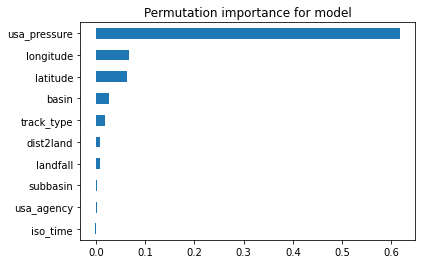

In [46]:
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

df2 = pd.DataFrame(data, index=X_test.columns)
df2.sort_values('importances_mean', ascending=True, inplace=True)

df2['importances_mean'].tail(10).plot(kind='barh')
plt.title('Feature importances for random forest model (My best model)');